In [88]:
import pandas as pd 
import numpy as np 
import re
import json 
from math import pi
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
import nltk
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 

Here we define what set of words we will do analysis on: 

In [103]:
masculine_themed_wording = [
    "competitive",
    "dominate",
    "leader",
    "rock star",
    "rockstar",
    "guru",
    "ninja",
    "hacker",
    "superhero",
    "prove themselves",
    "analyze",
    "determine",
    "crush it",
    "world class",
    "superior",
    "ambitious",
    "aggressive",
]
s = "active adventurous aggress ambitio analy assert athlet autonom battle boast challeng champion compet confident courag decid decision decisive defend determin domina dominant driven fearless fight force greedy head-strong headstrong hierarch hostil impulsive independen individual intellect lead logic objective opinion outspoken persist principle reckless self-confiden self-relian self-sufficien selfconfiden selfrelian selfsufficien stubborn superior unreasonab"
newWords = s.split()
# masculine_themed_wording += newWords
# masculine_themed_wording = list(set(masculine_themed_wording))

obviously_masculine_subset =[
    'competitive', 
    'dominate', 
    'rockstar',
    'rock star', 
    'ninja', 
    'superhero',
    'world class',
    'superior', 
    'ambitious', 
    'aggressive', 
    'ambitious', 
    'crush it', ]

feminine_themed_wording = '''agree
affectionate
child
cheer
collab
commit
compassion
connect
considerate
cooperat
co-operat
depend
emotiona
empath
feel
flatterable
gentle
honest
interpersonal
interdependen
interpersona
inter-personal
inter-dependen
inter-persona
kind
kinship
loyal
modesty
nag
nurtur
pleasant
polite
quiet
respon
sensitiv
submissive
sympath
tender
together
trust
warm
whin
enthusias
inclusive
yield
share
sharin'''.split()

We initialize data_set with our cleaned data set

In [4]:
data_set = pd.read_csv("../data/derived_job_data.csv")

In [57]:
data_set.head()

,job_title,company,location,description
0,MicroStrategy Developers HERE IN McLean VA (Fa...,Advansys Inc,VA,HelloPlease find the below requirement and do ...
1,Security Architect - Palo Alto Firewalls,Alagen,AZ,Alagen has combined over 20 years of recruitin...
2,Dynamics AX Senior System/Security Admin/Globa...,ConsultantFriends.com,IL,MS Dynamics System and Security Admin Global I...
3,IAM Consultant,Collabera,IL,Job ID5457_IAM_ILJob TitleIAM ConsultantJob Lo...
4,.Net Developer,Network Objects Inc.,CT,Net DeveloperHartford CTFULL TIMERequirements5...


In [58]:
#This function creates a list of stemmed words from a string
def stem_tokens(s): 
    ps = PorterStemmer()
    tokens = word_tokenize(s)
    stem = list(map(lambda x : ps.stem(x), tokens))
    
    return stem 

In [8]:
# descriptionDict = createTokenizedJobDescriptionDict(data_set)

In [9]:
# tokenized_description = data_set['description'].apply(lambda x: ' '.join(stem_tokens(x)))
tokenized_description = pd.read_csv('dataWithStemmedDescription.csv')['description']

In [59]:
def phraseCount(phrase, description): 
#this counts the amount of times phrase shows up in description
    s = '\\b(' + phrase + ')\\b'
    regex = re.compile(s,re.IGNORECASE)
    return len(re.findall(regex, description))

In [13]:
def indicesOfJobsWithPhrase(phrase, df, descriptionDict): 
# this given a phrase, data frame, stemmed description list
# it will find if the phrase is in the description or the stemmed description
# if it is it will return the indices of these jobs that contain this phrase
    indices = []
    for index, row in df.iterrows(): 
        stemmedPhrase = ' '.join(stem_tokens(phrase))
        if phraseCount(phrase,row.get('description')) > 0 \
        or phraseCount(stemmedPhrase, descriptionDict[index]) > 0: 
            indices.append(index)
    return indices

In [14]:
def computeStateInfo(state, full_df,descriptions,themed_wording): 
# this finds the information of the individual words for this state
# there will be a word count, indicies of the data set where it is found
# number percentage of biased jobs for this state
    stateInfo = {}
    stateInfo['region'] = state
    stateInfo['word_count'] = {}
    stateInfo['word_indices'] = {}
    state_df = full_df.where(full_df['location'] == state).dropna()
    biasedIndices = []; 
    
    for word in themed_wording: 
        
        indices = indicesOfJobsWithPhrase(word, state_df, descriptions)
        stateInfo['word_count'][word] = len(indices)
        stateInfo['word_indices'][word] = indices
        biasedIndices += indices
    
    topWords = [item[0] for item in reversed(sorted(stateInfo['word_count'].items(), key = lambda kv: kv[1]))][:5]
    
    stateInfo['numberOfJobsInDataSet'] = len(state_df)
    stateInfo['numberOfBiasedJobs'] = len(set(biasedIndices))
    try: 
        stateInfo['percentageOfBiasedJobs'] = float(stateInfo['numberOfBiasedJobs']/ stateInfo['numberOfJobsInDataSet']) * 100
    except ZeroDivisionError: 
        stateInfo['percentageOfBiasedJobs'] = 'NA'
                                                                                                               
    stateInfo['questionFour'] = topWords
    stateInfo['questionFive'] = {kv[0]: (kv[1] / stateInfo['numberOfJobsInDataSet'] * 100 if stateInfo['numberOfJobsInDataSet'] > 0 else 'NA')
                                         for kv in stateInfo['word_count'].items()}
    return stateInfo
    

In [104]:
def exportInfo(DF,themed_wording,name): 
# this function creates a list of dictionaries of state information for all states
# this also writes it to a csv file with the given name
    states = pd.read_csv("states.csv")
    data = [computeStateInfo(state, DF,tokenized_description,themed_wording) for state in states['Code']]
    stateData = data; 
    with open(name+'.json', 'w') as outfile:
        json.dump(stateData, outfile,indent = 4)
    return stateData
        

The following cell finds gathers the info from our data set, and our masculine themed wording and shows runtime

In [105]:
import time
startTime = time.time()

themed_wording = obviously_masculine_subset
name = 'obviouslyMasculineWording'
stateData = exportInfo(data_set,themed_wording,name)
runtime = time.time() - startTime
print("runtime:",runtime)

runtime: 114.12033319473267


In [113]:
# def countWords(stateData,themed_wording):
#     states = pd.read_csv("states.csv")
#     D = {word: 0 for word in themed_wording}
#     for state in stateData: 
#         for word in state['word_count']: 
#             D[word] += state['word_count'][word]
#     return D
# D = countWords(stateData,themed_wording)
with open (name+'.json') as jsonfile: 
    jsonInfo = json.load(jsonfile)


In [114]:
def getPercentages(stateData): 
    numberOfGenderedJobs = sum([state['numberOfBiasedJobs']for state in stateData])
    numberOfJobs = data_set.shape[0]
    percentageOfGenderedJobs = numberOfGenderedJobs / numberOfJobs * 100
    print('percentage of gendered jobs:', percentageOfGenderedJobs)
    print('number of gendered jobs:', numberOfGenderedJobs)

In [115]:
getPercentages(stateData)

percentage of gendered jobs: 12.387881203906717
number of gendered jobs: 2486


In [116]:
%matplotlib inline

In [117]:
import matplotlib.pyplot as plt

In [118]:
%matplotlib notebook

<IPython.core.display.Javascript object>


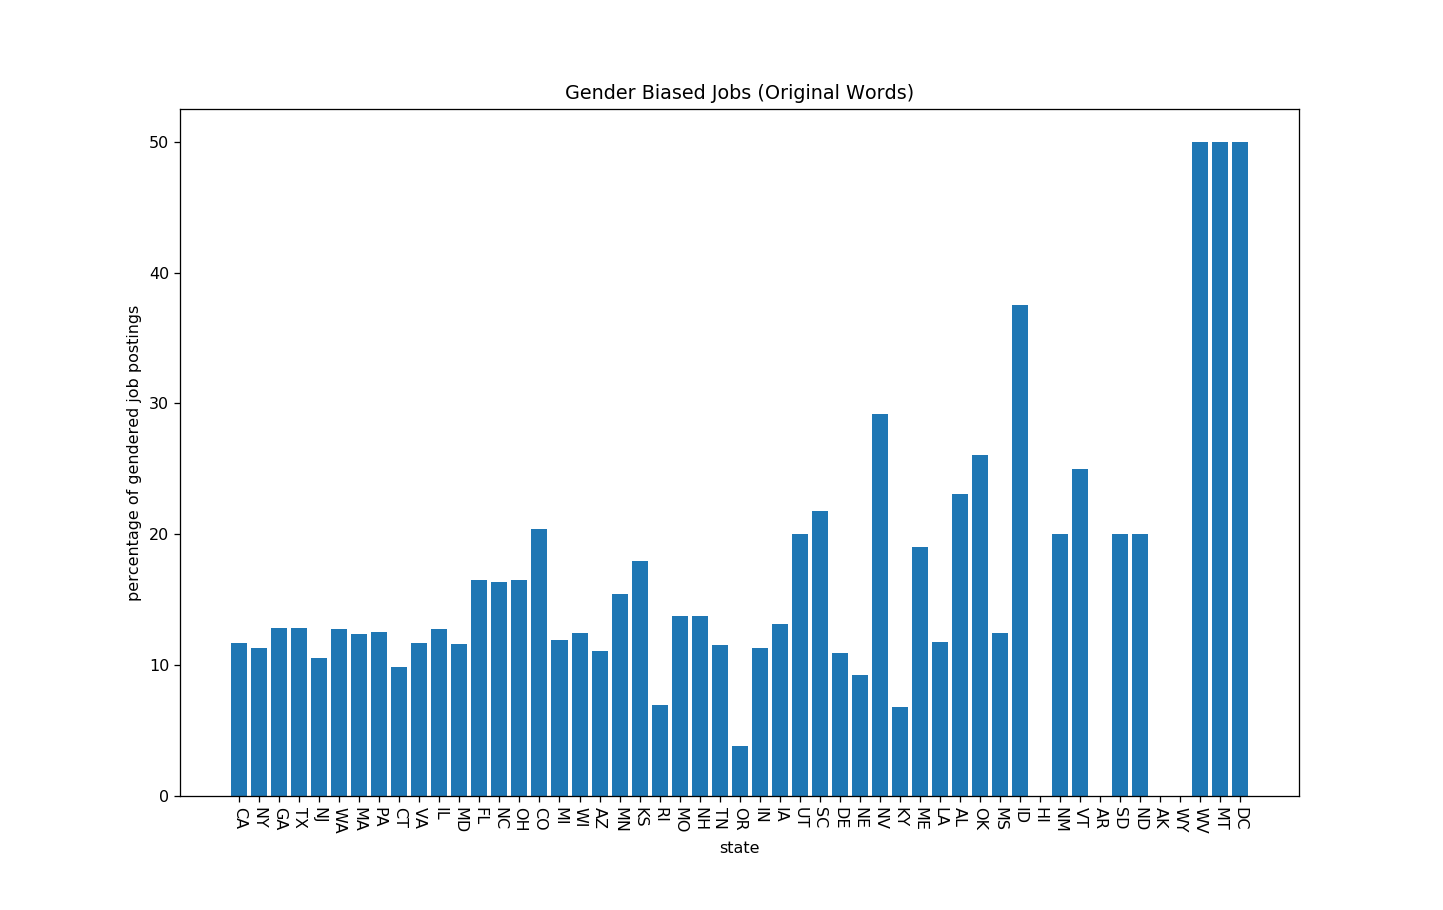

In [119]:
fig1 , ax = plt.subplots()

In [120]:
x = [state['region'] for state in reversed(sorted(stateData, key = lambda x: x['numberOfJobsInDataSet'])) if state['percentageOfBiasedJobs'] != 'NA']

In [121]:
y = [float(state['percentageOfBiasedJobs']) for state in reversed(sorted(stateData, key = lambda x: x['numberOfJobsInDataSet'])) if state['percentageOfBiasedJobs'] != 'NA']

In [122]:
ax.bar(x,y)
ax.tick_params(axis='x', which='major', rotation = 270)
ax.set_xlabel('state')
ax.set_ylabel('percentage of gendered job postings')
ax.set_title('Gender Biased Jobs (Original Words)')

Text(0.5, 1.0, 'Gender Biased Jobs (Original Words)')

In [112]:
p = figure(x_range=x,plot_width = 800, plot_height=600, title="Percentage Of Job Listings With Original Words",
        toolbar_location=None, tools="")

p.vbar(x = x, top = y, width =.8)
p.xaxis.major_label_orientation = pi/2
p.xaxis.axis_label = 'State'
p.yaxis.axis_label = 'Percentage'

# output_file(name+'.html')
show(p)

In [ ]:
fig2, ax2 = plt.subplots()
plt.yscale('log')

In [ ]:
x2 = [state['region'] for state in reversed(sorted(stateData, key = lambda x: x['numberOfJobsInDataSet']))] 

In [ ]:
y2 = [state['numberOfJobsInDataSet'] for state in reversed(sorted(stateData, key = lambda x: x['numberOfJobsInDataSet']))]

In [ ]:
ax2.bar(x2,y2)
ax2.tick_params(axis='x', which='major', rotation = 270)
ax2.set_ylabel('number of job listings')
ax2.set_xlabel('state')

In [ ]:
def findNumberOfJobsWithPronouns(data_set): 
    mpronouns = ['he', 'him' ,'his']
    fpronouns = ['she', 'her', 'hers']
    pronounCounter = 0
    mascPronounCounter = 0
    femPronounCounter = 0
    for index, row in data_set.iterrows():
        mcount = 0
        fcount = 0
        for word in mpronouns: 
            mcount += phraseCount(word, row.get('description'))
        for word in fpronouns: 
            fcount += phraseCount(word, row.get('description'))
        if mcount + fcount > 0:
            pronounCounter +=1 
        if mcount > fcount: 
            mascPronounCounter += 1
        if mcount < fcount: 
            femPronounCounter += 1

    print('number of jobs that have gendered pronouns:', pronounCounter)
    print('more masculine pronouns:', mascPronounCounter)
    print('more feminine pronouns:', femPronounCounter)
findNumberOfJobsWithPronouns(data_set)

In [80]:
graphPercentages(data_json, genderedPhrase, graphName): 
x = [state['region'] for state in reversed(sorted(data_json, key = \
    lambda x: x['numberOfJobsInDataSet'])) if state['percentageOfBiasedJobs'] != 'NA']
y = [float(state['percentageOfBiasedJobs']) for state in reversed(sorted(data_json,\
    key = lambda x: x['numberOfJobsInDataSet'])) if state['percentageOfBiasedJobs'] != 'NA']
y = {

TypeError: unhashable type: 'dict'